# Natural Language Processing - Consumer Complaint in bank sector

### Research question: 

* How to develop an automatic text classification model that assigns customer complaints to the correct product categories based on their content?

Authors: Alam Jasia, Hubweber Michaela, Schumich Kathrin, Ye Florian

Dataset: https://www.kaggle.com/datasets/shashwatwork/consume-complaints-dataset-fo-nlp

## State of the Art

1. What has been researched so far?
* Classifying customer complaints into predefined categories using advanced NLP techniques
* Various machine learning and deep learning techniques
* Word embeddings to capture semantic relationships in complaint texts
* Studies show high accuracy in categorizing consumer complaints based on text
* Some approaches also use dimensionality reduction for better data visualization and grouping

2. What are common approaches/models?
* Traditional Methods:  Naïve Bayes, Decision Trees, Support Vector Machines, Generalized Linear Model
* More advanced approaches: LSTM, GRU, and CNN
* Word Embeddings (Word2Vec, BERT)
* Transformer Models (DistilBERT and FinBERT)
* Sentiment analysis to identify trends

Similar work and differences from ours? Existing research has explored the categorization of customer complaints, particularly through the use of NLP techniques to analyze text. However, our work **placeholder**

**References**
* Vinayak, V., & C., J. (2023). Consumer Complaints Classification using Deep Learning & Word Embedding Models. 2023 14th International Conference on Computing Communication and Networking Technologies (ICCCNT), 1-5.
* Kohler, M., Sondermann, L., Forero, L., & Pacheco, M.A. (2018). Classifying and Grouping Narratives with Convolutional Neural Networks, PCA and t-SNE. International Conference on Health Information Science.
* Research, M., & Rafiee, D.M. (2020). Analysis of Customer Complaint Data of Consumer Financial Protection Bureau Using Different Text Classification Methods.
* Correa, N., & Correa, A. (2022). Neural Text Classification for Digital Transformation in the Financial Regulatory Domain. 2022 IEEE ANDESCON, 1-6.



##### All necessary packages 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from IPython.display import display
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from scipy import stats
from textblob import TextBlob

import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from sentence_transformers import SentenceTransformer
import zipfile

from gensim.models import Word2Vec
from narrative_to_vec import tokenize_column, add_column_average_genre_vector

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [107]:
# Load spaCy's English language model for lemmatization
# python -m spacy download en_core_web_sm
spacy_nlp = spacy.load("en_core_web_sm")

## Pre-Processing

* Cleaning
* Stemming
* Lemmatization
* Tokenization

Reading in the data and removing the index column.

In [108]:
# Load data
data = pd.read_csv('/Users/jasiaalam/Desktop/WS24_NLP/complaints_processed.csv')
# Delete first row (index)
data = data.drop(data.columns[0], axis=1)

data.head()

,product,narrative
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


Überprüfung auf fehlende Werte. Da nur 10 von 160k der Narratives fehlen, werden sie einfach entfernt.

In [109]:
# Check the number of rows
print("Number of rows: ", data.shape[0])
# Check for missing values
print("Number of missing values: ", data.isnull().sum().sum())
data = data.dropna() #drop missing values
# Check number of rows after dropping missing values
print("Number of rows after dropping missing values ", data.shape[0])

Number of rows:  162421
Number of missing values:  10
Number of rows after dropping missing values  162411


Check whether HTML tags, punctuation and numbers are present and whether content is written in Upper Case. Since this is not the case, no transformations are carried out in this sense.

In [110]:
print("Number of rows with html tags:", data['narrative'].str.contains('<.*?>', regex=True).sum())
print("Number of rows with punctuation:", data['narrative'].str.contains('[^\w\s]', regex=True).sum())
print("Number of rows with numbers:", data['narrative'].str.contains('\d', regex=True).sum())
print("Number of rows with uppercase:", data['narrative'].str.contains('[A-Z]', regex=True).sum())

Number of rows with html tags: 0
Number of rows with punctuation: 0
Number of rows with numbers: 0
Number of rows with uppercase: 0


In [111]:
# Clculate length of narrative (before preprocessing)
data['narrative_len'] = data['narrative'].apply(lambda text: len(text.split()))

Creating a new column that removes stop words from narrative. Remove the rows with less than 4 words in the new column as they are hardly meaningful and represent only a fraction of the total data

In [112]:
# Create a columns for the cleaned narrative
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Remove stopwords
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

data['narrative_prep'] = data['narrative'].apply(lambda text: remove_stopwords(text))

In [113]:
# Show number of that are empty after removing stop words
print("Number of rows with empty narratives after removing stop words:", data[data['narrative_prep'] == ''].shape[0])
# Show number of rows with narratives that have less than 4 words
print("Number of rows with narratives that have less than 4 words:", data[data['narrative_prep'].str.split().apply(len) < 4].shape[0])

# Remove rows with narratives that have less than 4 words
data = data[data['narrative_prep'].str.split().apply(len) >= 4]

# Show number of rows after removing rows
print("Number of rows after removing rows", data.shape[0])

Number of rows with empty narratives after removing stop words: 7
Number of rows with narratives that have less than 4 words: 1756
Number of rows after removing rows 160655


In [114]:
# Process large text as a stream via `nlp.pipe()` and iterate over the results, extracting lemmas
#lemma_text_list = []
#for doc in spacy_nlp.pipe(data["narrative_prep"]):
#    lemma_text_list.append(" ".join(token.lemma_ for token in doc))
#data["text_lemma"] = lemma_text_list

In [115]:
# Calculate the length of lemmatized narrative
data['narrative_prep_len'] = data['narrative_prep'].apply(lambda text: len(text.split()))

In [116]:
data.head()

,product,narrative,narrative_len,narrative_prep,narrative_prep_len
0,credit_card,purchase order day shipping amount receive pro...,230,purchase order day shipping receive product we...,203
1,credit_card,forwarded message date tue subject please inve...,132,forwarded message date tue subject investigate...,121
2,retail_banking,forwarded message cc sent friday pdt subject f...,173,forwarded message cc sent friday pdt subject f...,147
3,credit_reporting,payment history missing credit report speciali...,131,payment history missing credit report speciali...,110
4,credit_reporting,payment history missing credit report made mis...,123,payment history missing credit report mistake ...,102


## Explorative Data Analysis

In [117]:
print(data.dtypes)


product               object
narrative             object
narrative_len          int64
narrative_prep        object
narrative_prep_len     int64
dtype: object


In [118]:
# Count the occurrences of each product type
product_counts = data['product'].value_counts()
product_counts

product
credit_reporting       89748
debt_collection        22987
mortgages_and_loans    18955
credit_card            15530
retail_banking         13435
Name: count, dtype: int64

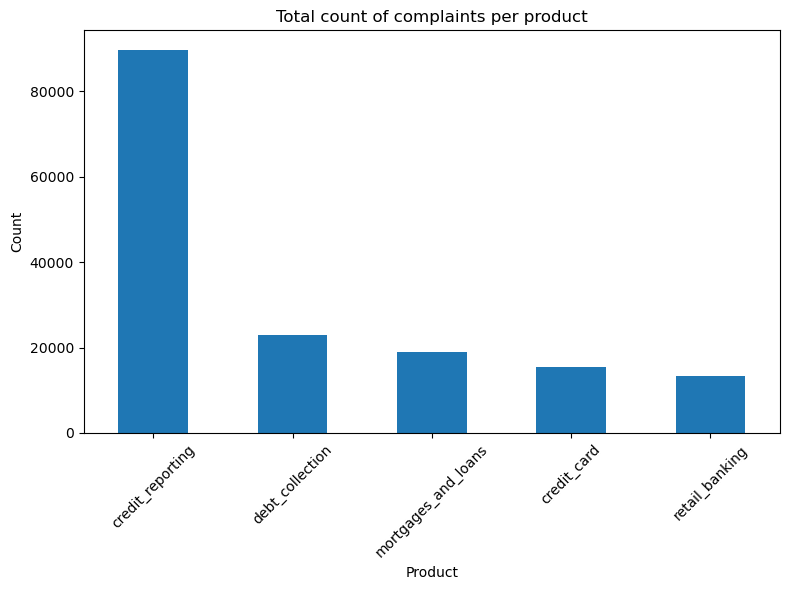

In [119]:
# Create the plot
plt.figure(figsize=(8, 6))
product_counts.plot(kind='bar')
plt.title('Total count of complaints per product')
plt.xlabel('Product')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjusts layout to prevent label cutoff
plt.show()

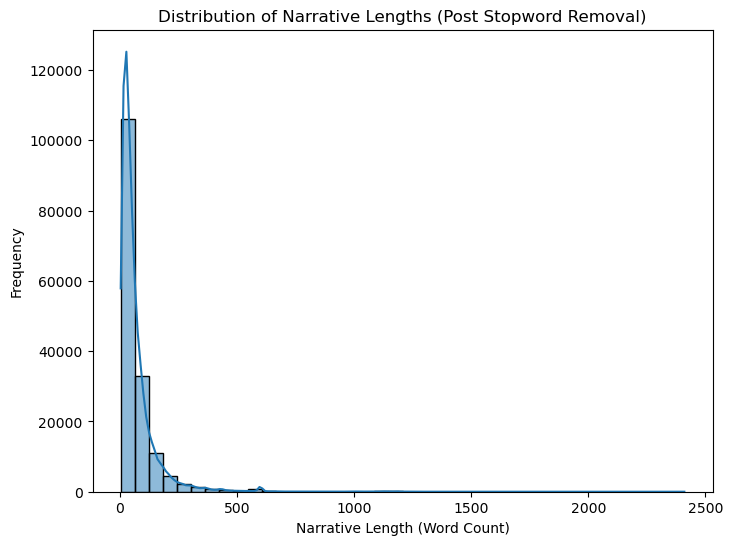

In [120]:
# Distribution of Narrative Lengths (after stopword removal)
plt.figure(figsize=(8, 6))
sns.histplot(data['narrative_prep_len'], bins=40, kde=True)
plt.title('Distribution of Narrative Lengths (Post Stopword Removal)')
plt.xlabel('Narrative Length (Word Count)')
plt.ylabel('Frequency')
plt.show()

In [121]:
# 1. Overall Summary Statistics for length_narrative_preprocessed
overall_summary = data['narrative_prep_len'].describe()

# Display overall summary statistics
print("Overall Summary Statistics - length_narrative_preprocessed:")
display(overall_summary)

Overall Summary Statistics - length_narrative_preprocessed:


count    160655.000000
mean         71.113342
std          97.334293
min           4.000000
25%          24.000000
50%          44.000000
75%          83.000000
max        2410.000000
Name: narrative_prep_len, dtype: float64

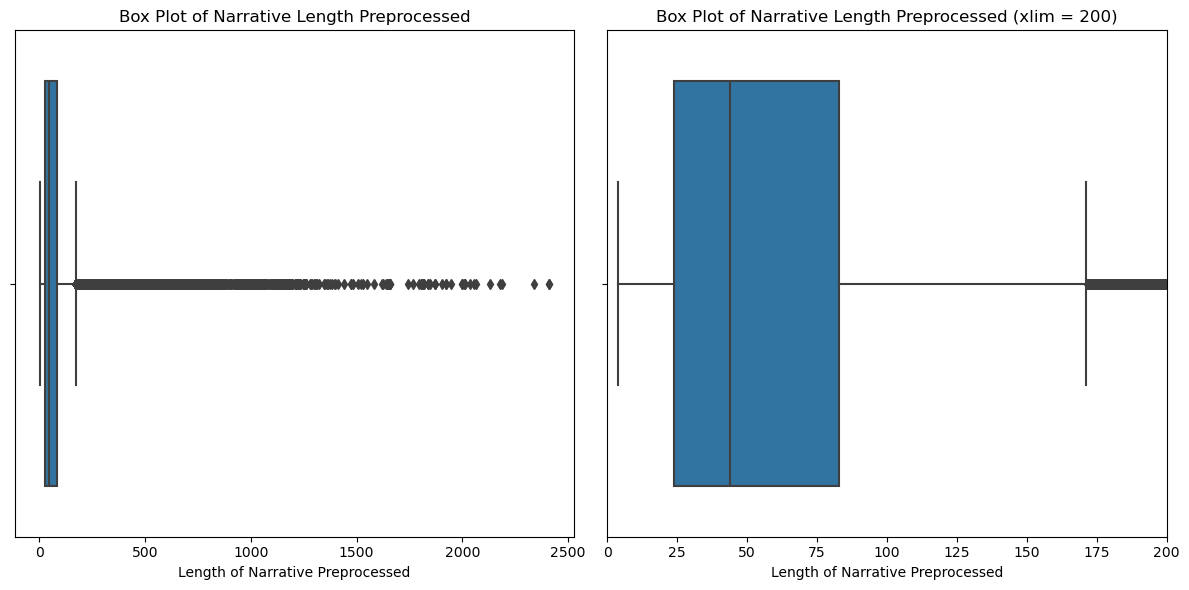

In [122]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot of overall narrative length on the first subplot
sns.boxplot(x=data['narrative_prep_len'], ax=axes[0])  # Create the boxplot
axes[0].set_title('Box Plot of Narrative Length Preprocessed')
axes[0].set_xlabel('Length of Narrative Preprocessed')

# Boxplot of overall narrative length (with xlim=200) on the second subplot
sns.boxplot(x=data['narrative_prep_len'], ax=axes[1])  # Create the boxplot
axes[1].set_xlim(0, 200)  # Set the x-axis limit
axes[1].set_title('Box Plot of Narrative Length Preprocessed (xlim = 200)')
axes[1].set_xlabel('Length of Narrative Preprocessed')

plt.tight_layout()
plt.show()

In [123]:
# 2. Group-wise Summary Statistics for each product
grouped_summary = data.groupby('product')['narrative_prep_len'].describe()

# Display group-wise summary statistics
print("\nGroup-wise Summary Statistics by Product:")
display(grouped_summary)


Group-wise Summary Statistics by Product:


,count,mean,std,min,25%,50%,75%,max
product,,,,,,,,
credit_card,15530.0,84.479395,85.383704,4.0,34.0,61.0,106.0,2038.0
credit_reporting,89748.0,61.205943,94.411572,4.0,21.0,36.0,65.0,2410.0
debt_collection,22987.0,69.811241,99.643645,4.0,23.0,44.0,83.0,2064.0
mortgages_and_loans,18955.0,101.391295,112.176236,4.0,41.0,72.0,121.0,2341.0
retail_banking,13435.0,81.355787,91.190146,4.0,28.0,57.0,101.0,1581.0


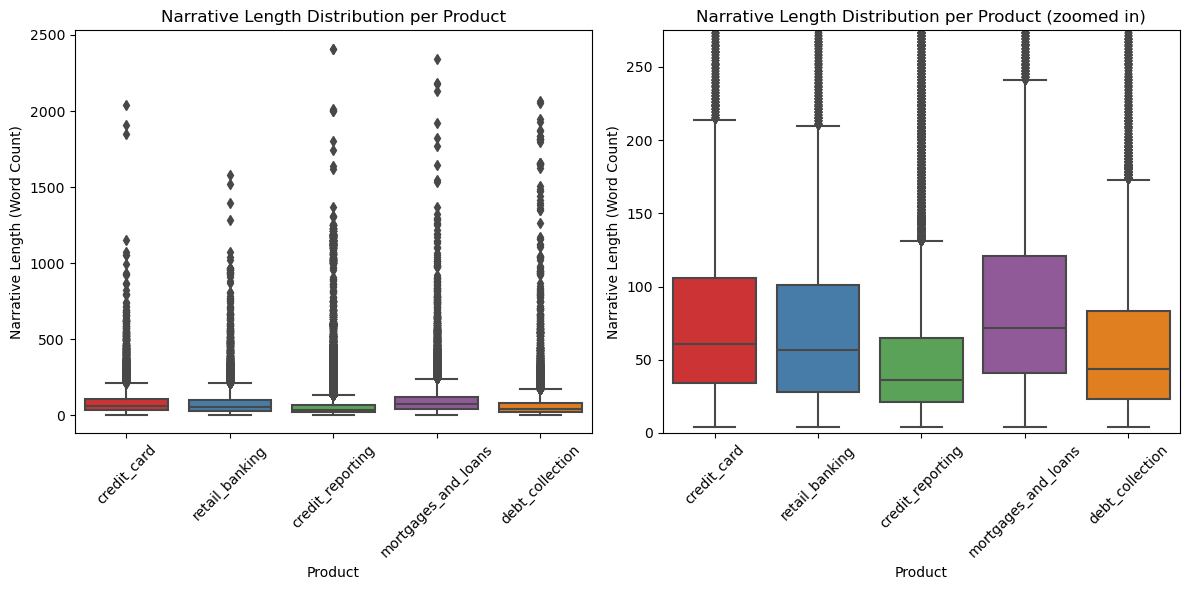

In [124]:
# Boxplot of Narrative Length per Product
def boxplot_narrative_length(data, title, ylim: int = None, ax=None):
    if ax is None:
        ax = plt.gca()
    sns.boxplot(x='product', y='narrative_prep_len', data=data, palette='Set1', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Product')
    ax.set_ylabel('Narrative Length (Word Count)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    if ylim is not None:
        ax.set_ylim(0, ylim)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first boxplot
boxplot_narrative_length(data, title='Narrative Length Distribution per Product', ax=axes[0])

# Plot the second boxplot with a y-limit of 275
boxplot_narrative_length(data, title='Narrative Length Distribution per Product (zoomed in)', ylim=275, ax=axes[1])

plt.tight_layout()
plt.show()

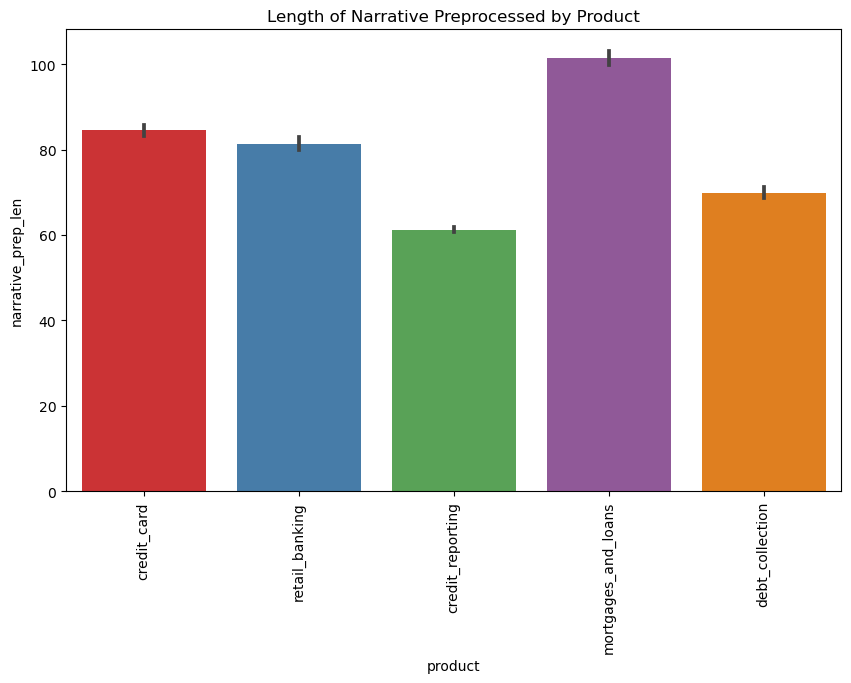

In [125]:
# Barplot of Narrative length per Product
plt.figure(figsize=(10,6))
sns.barplot(data=data, x='product', y='narrative_prep_len', palette ='Set1')
plt.xticks(rotation=90)
plt.title('Length of Narrative Preprocessed by Product')
plt.show()

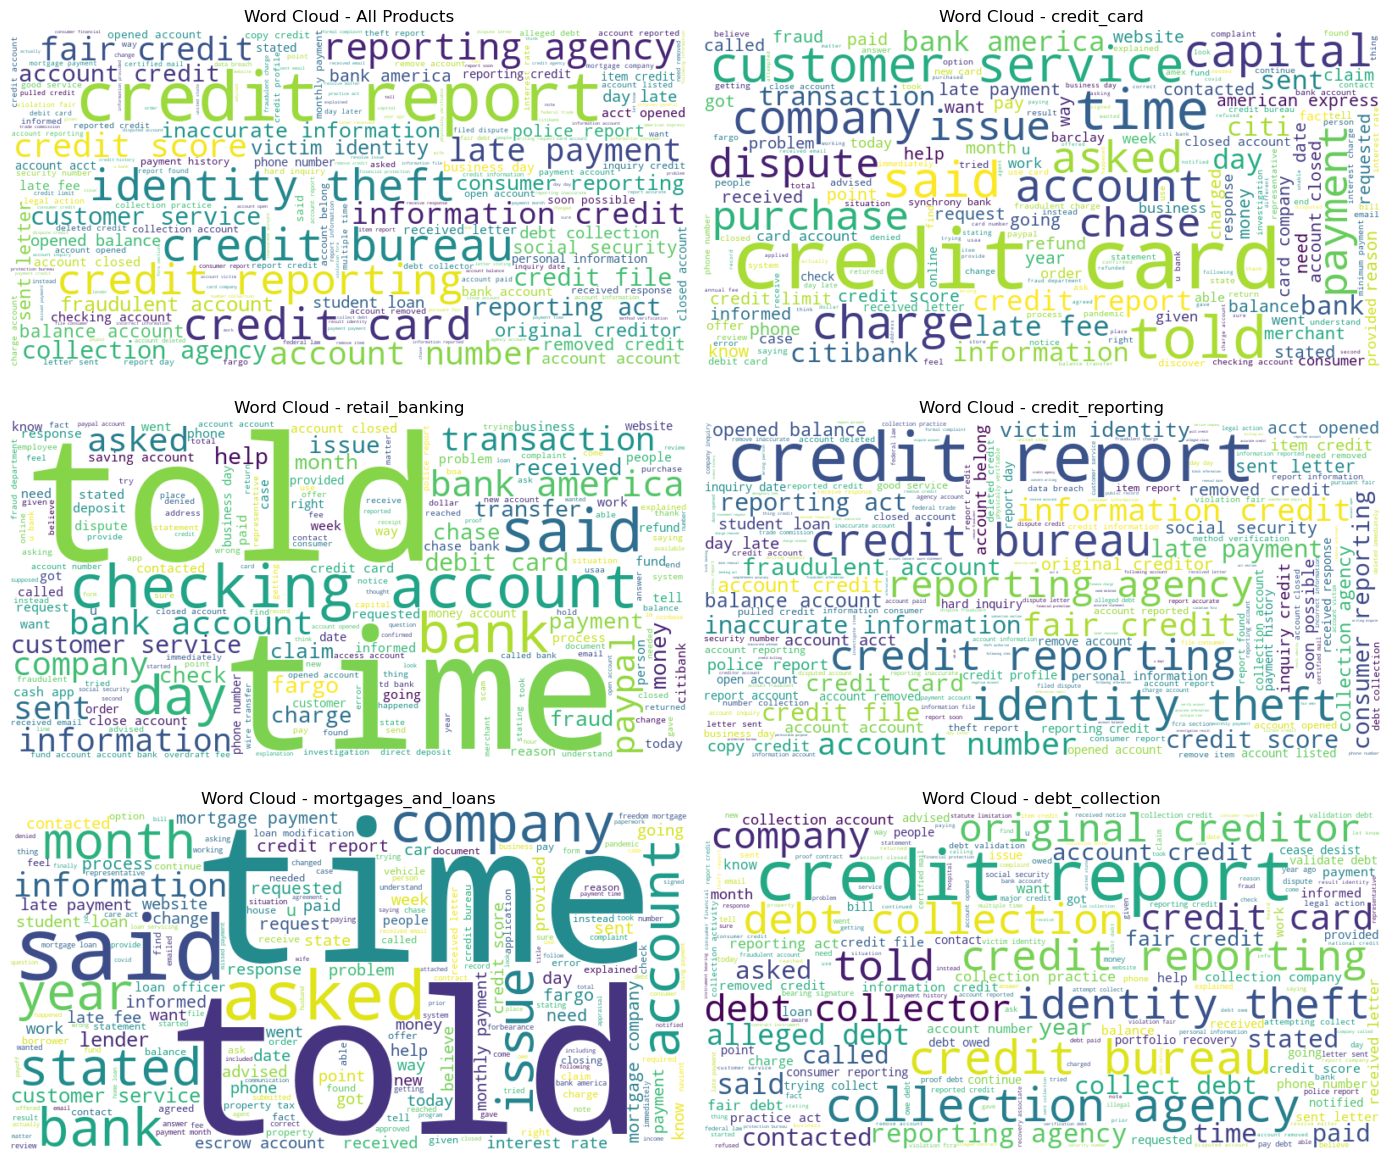

In [126]:
# Word clouds for the entire dataset and five for each product category
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Generate word cloud for the whole dataset
all_words = ' '.join(data['narrative_prep'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
axes[0, 0].imshow(wordcloud, interpolation='bilinear')
axes[0, 0].axis('off')
axes[0, 0].set_title('Word Cloud - All Products')

# Generate word clouds for each product category
product_categories = data['product'].unique()

for i, product in enumerate(product_categories):
    product_words = ' '.join(data[data['product'] == product]['narrative_prep'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(product_words)
    row, col = divmod(i + 1, 2)
    axes[row, col].imshow(wordcloud, interpolation='bilinear')
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Word Cloud - {product}')

# Remove any unused subplots
for j in range(len(product_categories) + 1, 6):
    row, col = divmod(j, 3)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

##### Conclusion EDA:

* The classes are very similar and the words that appear in the text regarding the categories match a lot. Therefore the dataset seems to be more challenging than expected at the beginning. 
* Package TextBlob not suited for the purpose of this project, therefore redo setimental analysis. 
* The size of the dataset can also be a challenge thus one can take a subset of the dataset due to technical and time limit.

## Feature Engineering

In [127]:
data['word_count'] = data['narrative'].apply(lambda x: len(x.split()))
data['char_count'] = data['narrative'].apply(lambda x: len(x))
data['sentence_count'] = data['narrative'].apply(lambda x: len(x.split('.')))

data[['narrative', 'word_count', 'char_count', 'sentence_count']].head()

,narrative,word_count,char_count,sentence_count
0,purchase order day shipping amount receive pro...,230,1705,1
1,forwarded message date tue subject please inve...,132,904,1
2,forwarded message cc sent friday pdt subject f...,173,1230,1
3,payment history missing credit report speciali...,131,903,1
4,payment history missing credit report made mis...,123,851,1


 ### TF-IDF
Extracting key text features using TF-IDF

In [128]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=20)
tfidf_matrix = tfidf.fit_transform(data['narrative_prep'])

# Create a DataFrame with TF-IDF features
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
display(tfidf_df.head())

,account,bank,card,collection,company,consumer,credit,day,debt,dispute,information,letter,loan,payment,received,report,reporting,sent,time,told
0,0.000000,0.000000,0.280322,0.0,0.232382,0.000000,0.000000,0.473728,0.000000,0.541298,0.0,0.000000,0.000000,0.000000,0.23051,0.000000,0.000000,0.498774,0.219286,0.000000
1,0.188362,0.577591,0.453650,0.0,0.470085,0.000000,0.398988,0.000000,0.114002,0.000000,0.0,0.000000,0.000000,0.098216,0.00000,0.000000,0.000000,0.100897,0.000000,0.110072
2,0.384088,0.000000,0.693779,0.0,0.000000,0.400155,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.300410,0.00000,0.000000,0.152749,0.154304,0.271359,0.000000
3,0.189081,0.347878,0.000000,0.0,0.000000,0.000000,0.171648,0.000000,0.000000,0.000000,0.0,0.204487,0.579487,0.591550,0.00000,0.279791,0.000000,0.000000,0.089057,0.000000
4,0.213398,0.392617,0.000000,0.0,0.000000,0.000000,0.193723,0.000000,0.000000,0.000000,0.0,0.230785,0.392407,0.667626,0.00000,0.315773,0.000000,0.000000,0.100511,0.000000


In [129]:
tfidf_df

,account,bank,card,collection,company,consumer,credit,day,debt,dispute,information,letter,loan,payment,received,report,reporting,sent,time,told
0,0.000000,0.000000,0.280322,0.000000,0.232382,0.000000,0.000000,0.473728,0.000000,0.541298,0.000000,0.000000,0.000000,0.000000,0.230510,0.000000,0.000000,0.498774,0.219286,0.000000
1,0.188362,0.577591,0.453650,0.000000,0.470085,0.000000,0.398988,0.000000,0.114002,0.000000,0.000000,0.000000,0.000000,0.098216,0.000000,0.000000,0.000000,0.100897,0.000000,0.110072
2,0.384088,0.000000,0.693779,0.000000,0.000000,0.400155,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.300410,0.000000,0.000000,0.152749,0.154304,0.271359,0.000000
3,0.189081,0.347878,0.000000,0.000000,0.000000,0.000000,0.171648,0.000000,0.000000,0.000000,0.000000,0.204487,0.579487,0.591550,0.000000,0.279791,0.000000,0.000000,0.089057,0.000000
4,0.213398,0.392617,0.000000,0.000000,0.000000,0.000000,0.193723,0.000000,0.000000,0.000000,0.000000,0.230785,0.392407,0.667626,0.000000,0.315773,0.000000,0.000000,0.100511,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160650,0.446069,0.164139,0.000000,0.171242,0.000000,0.371783,0.242965,0.000000,0.000000,0.000000,0.365013,0.000000,0.000000,0.000000,0.000000,0.099010,0.567673,0.286727,0.000000,0.000000
160651,0.477546,0.878607,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
160652,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.453761,0.000000,0.453783,0.000000,0.000000,0.405430,0.000000,0.000000,0.371218,0.000000,0.000000,0.401617,0.353142,0.000000
160653,0.000000,0.000000,0.000000,0.000000,0.631436,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.775428,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


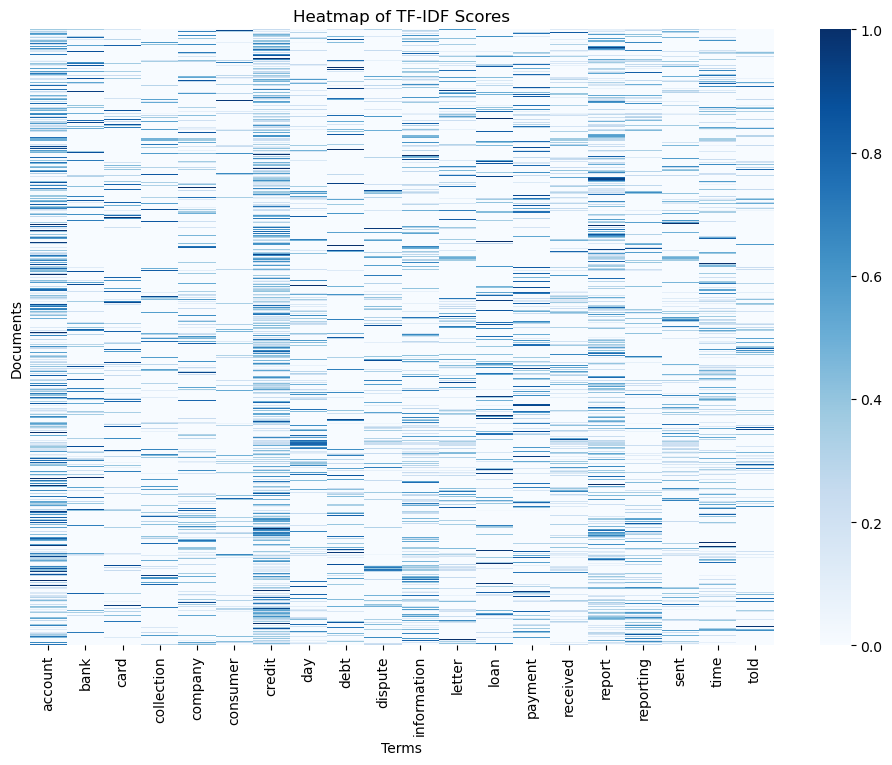

In [130]:
# Plot a heatmap of the TF-IDF matrix
plt.figure(figsize=(12, 8))
sns.heatmap(tfidf_df, cmap='Blues', yticklabels=False)
plt.title('Heatmap of TF-IDF Scores')
plt.xlabel('Terms')
plt.ylabel('Documents')
plt.show()

The heatmap shows how the TF-IDF scores are distributed across different narratives (documents).

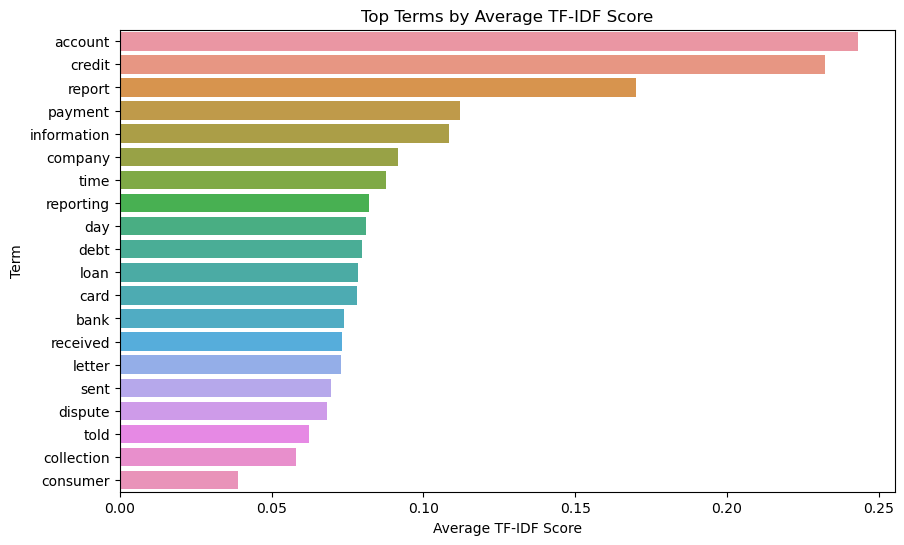

In [131]:
# Get the average TF-IDF score for each term across all documents
tfidf_mean = tfidf_df.mean().sort_values(ascending=False)

# Plot the top terms by average TF-IDF score
plt.figure(figsize=(10, 6))
sns.barplot(x=tfidf_mean.values, y=tfidf_mean.index)
plt.title('Top Terms by Average TF-IDF Score')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Term')
plt.show()

#### Top words by TF-IDF score by products:

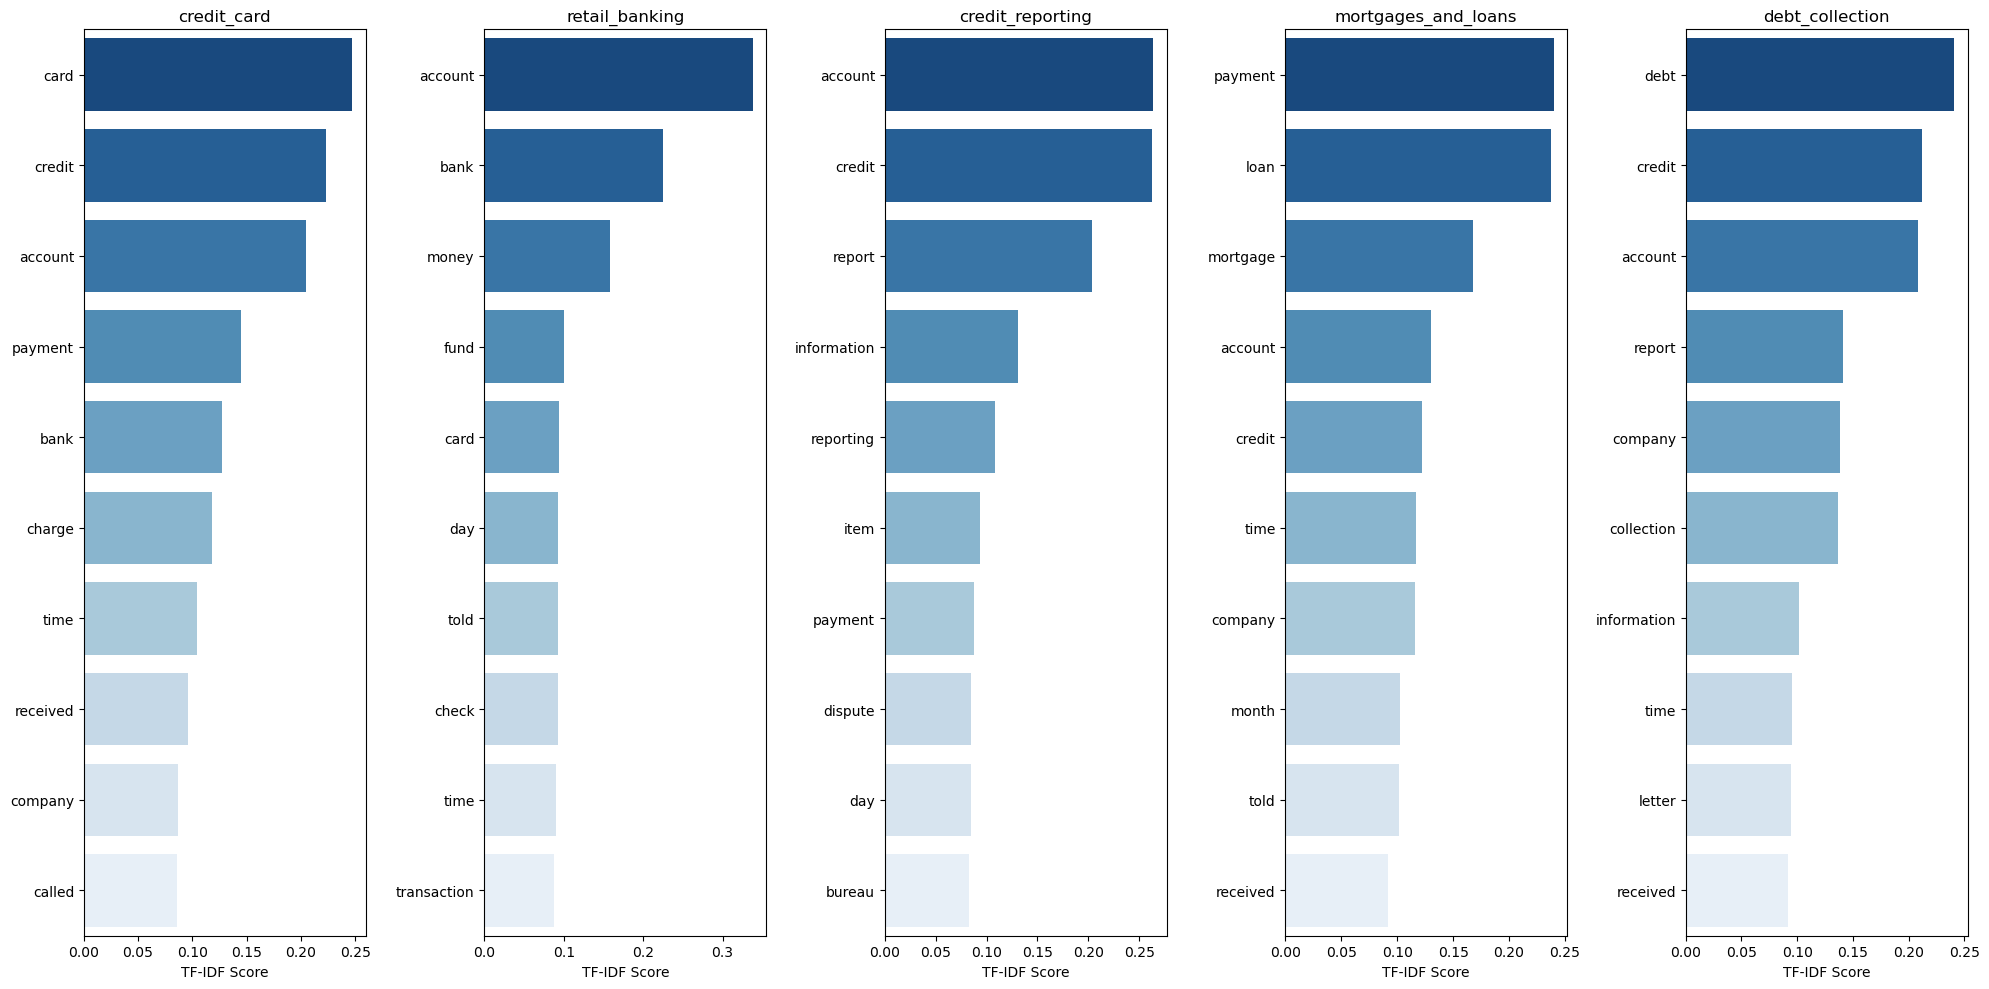

In [132]:
products = data['product'].unique()

# Initialize a TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=20)

# Create a figure with a 2x5 grid of subplots (adjust the number of rows and columns based on your product count)
fig, axes = plt.subplots(1, 5, figsize=(20, 10))
axes = axes.flatten()  # Flatten to easily index subplots

# Iterate through each product and its corresponding subplot
for i, product in enumerate(products):
    # Filter the data for the current product
    product_data = data[data['product'] == product]
    
    # Apply TF-IDF on the 'narrative_prep' column for the current product
    tfidf_matrix = tfidf.fit_transform(product_data['narrative_prep'])
    
    # Create a DataFrame with the TF-IDF scores for each term
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
    
    # Compute the average TF-IDF score for each term
    tfidf_mean = tfidf_df.mean().sort_values(ascending=False)
    
    # Take the top 10 terms with the highest TF-IDF scores
    top_words = tfidf_mean.head(10)
    
    # Plot the top words for this product in its corresponding subplot
    sns.barplot(x=top_words.values, y=top_words.index, ax=axes[i], palette = 'Blues_r')
    axes[i].set_title(f'{product}')
    axes[i].set_xlabel('TF-IDF Score')
    axes[i].set_ylabel('')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

#### Sentiment-Analyse: 
Conducting sentiment analysis to find out whether the text is negative, neutral or positive.

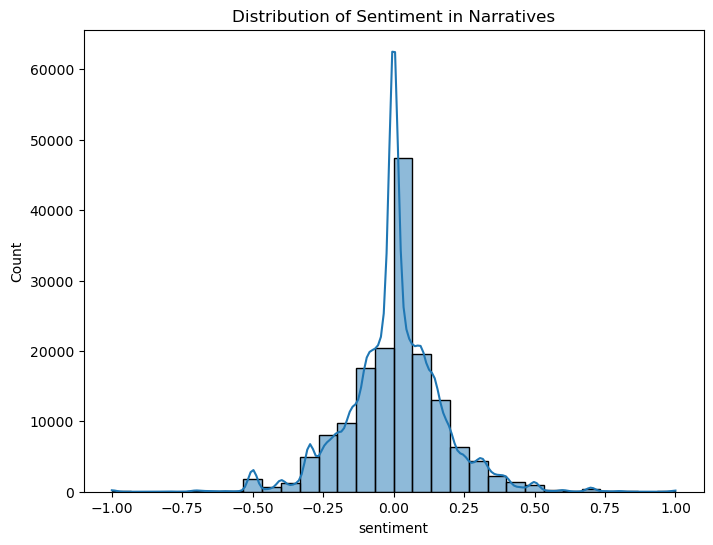

In [133]:
data['sentiment'] = data['narrative_prep'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plot sentiment distribution
plt.figure(figsize=(8,6))
sns.histplot(data['sentiment'], bins=30, kde=True)
plt.title('Distribution of Sentiment in Narratives')
plt.show()

The calculated sentiment score ranges from -1 (negative), to 0 (neutral) and 1 (positive).

#### Sentiment-Analyse by products:

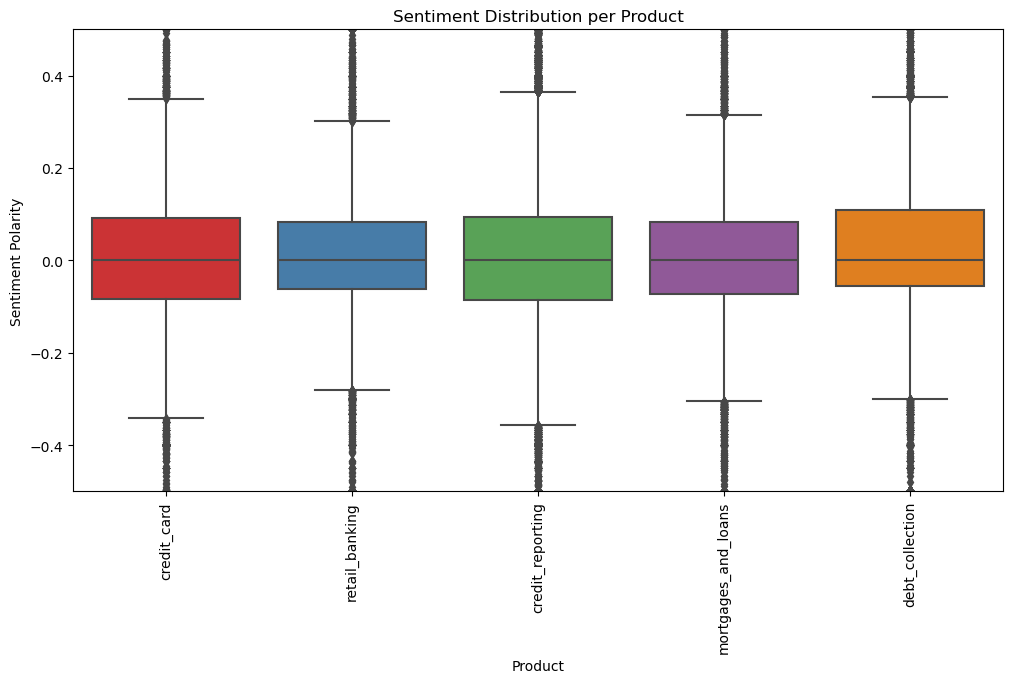

In [134]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='product', y='sentiment', palette='Set1')
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5)
plt.title('Sentiment Distribution per Product')
plt.ylabel('Sentiment Polarity')
plt.xlabel('Product')
plt.show()

### One-Hot Encoding

In [135]:
from sklearn.preprocessing import LabelEncoder  # For encoding labels
 #Step 3: Encode the target variable (Product Categories)
le = LabelEncoder()
y = le.fit_transform(data['product'])  # Transform product categories into numerical labels
y

array([0, 0, 4, ..., 2, 3, 2])

## Distributed Representations 

### Cosine Similarity

***Goal: Try out different embeddings to see, how (or if) the product categories can be clustered by cosine similarity.***

In [136]:
# Data Loading
#data_path = os.path.join("data", "data_eda.zip")
data_path = os.path.join("data", "/Users/jasiaalam/Desktop/WS24_Artificial Intelligence/data_eda.zip")
data = pd.read_csv(data_path)
data.head()

,product,narrative,narrative_len,narrative_prep,text_lemma,narrative_prep_len,sentiment
0,credit_card,purchase order day shipping amount receive pro...,230,purchase order day shipping receive product we...,purchase order day shipping receive product we...,203,0.078905
1,credit_card,forwarded message date tue subject please inve...,132,forwarded message date tue subject investigate...,forward message date tue subject investigate c...,121,-0.016748
2,retail_banking,forwarded message cc sent friday pdt subject f...,173,forwarded message cc sent friday pdt subject f...,forward message cc send friday pdt subject fin...,147,-0.010000
3,credit_reporting,payment history missing credit report speciali...,131,payment history missing credit report speciali...,payment history miss credit report specialized...,110,0.061483
4,credit_reporting,payment history missing credit report made mis...,123,payment history missing credit report mistake ...,payment history miss credit report mistake acc...,102,0.061483


In [137]:
# write a function to get and plot cosine similiraty by product category
def plot_cosine_similarity(embeddings, name):
    cosine_sim = cosine_similarity(embeddings)
    # plot the cosine similarity matrix
    sns.heatmap(cosine_sim, annot=True, cmap='coolwarm',
                xticklabels=embeddings.index,
                yticklabels=embeddings.index
                ).set_title("Cosine Similarity Matrix for " + name)  

#### 1) TFIDF on lemmatized text
* Updated TFIDF (inclusive Feedback Presentation 1)

In [138]:
# Create a TF-IDF vectorizer and fit it on the complaints
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(data['text_lemma'])
# Convert to a dataframe for easier manipulation
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [139]:
# Add the categories back to the dataframe
tfidf_df['product'] = data['product'].values
# Group by category and calculate the average TF-IDF values for each
category_embeddings = tfidf_df.groupby('product').mean()

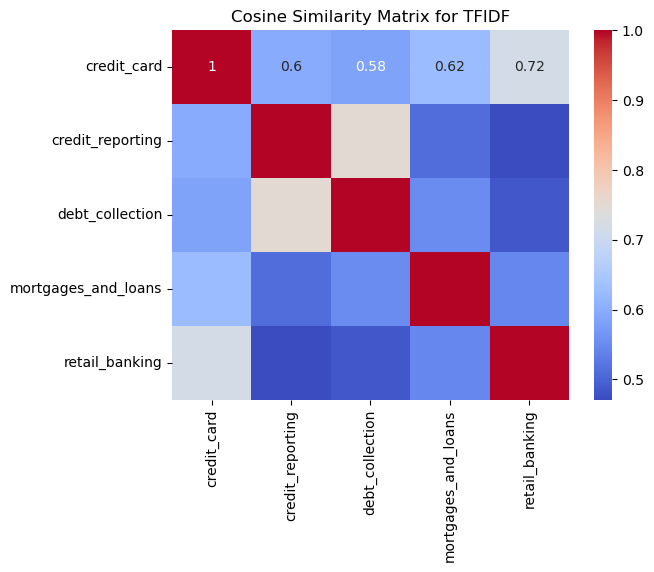

In [140]:
plot_cosine_similarity(category_embeddings, "TFIDF")

### Glove

#### 2) GLOVE on lemmatized text

The used model glove.6B.100d.txt is to large to push to github, but can be downloaded from https://nlp.stanford.edu/projects/glove/ and should be placed in the data folder.

In [141]:
# Load the model
def load_glove_model():
    zip_path = os.path.join("data", "glove.6B.100d.zip")
    glove_file = os.path.join("data", "glove.6B.100d.txt")

    #unzip the file if not already unzipped
    if not os.path.exists(glove_file):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall("data")
        
    glove_model = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            glove_model[word] = vector
    return glove_model

# Get the average GloVe embedding for a complaint
def get_average_embedding(text, glove_model):
    words = text.split()
    embeddings = []
    for word in words:
        if word in glove_model:
            embeddings.append(glove_model[word])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(100)

# Load Model and get embeddings
glove_model = load_glove_model()
#get_embedding(data["text_lemma"][0], glove_model)
glove_df = data['text_lemma'].apply(lambda x: get_average_embedding(x, glove_model)).to_frame()
glove_df['product'] = data['product'].values
glove_df = glove_df.groupby('product')['text_lemma'].apply(np.mean)
glove_df = pd.DataFrame(glove_df.tolist(), index=glove_df.index)
glove_df
plot_cosine_similarity(glove_df, "GloVe")


FileNotFoundError: [Errno 2] No such file or directory: 'data/glove.6B.100d.zip'

#### 3) Sentence transformers on unleammatized text:

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
sbert = model.encode(data["narrative_prep"])

In [ ]:
sbert_df = pd.DataFrame(sbert)
sbert_df['product'] = data['product'].values
sbert_df = sbert_df.groupby('product').mean()
plot_cosine_similarity(sbert_df, "SBERT")

### Word-to-Vec

Run the Code below as an own .py file (**narrative_to_vec.py**). Just put into the notebook in order to document everything!

In [ ]:
# Read data
#def read_data(folder_name, zip):
#    data_path = os.path.join(folder_name, zip)
#    data = pd.read_csv(data_path)

#    return data

# Tokenize the column
#def tokenize_column(data, text_col, new_col):
#    data[new_col] = data[text_col].apply(lambda x: x.split())
    
#    return data


# Train a Word2Vec model on the genres
#def train_word2vec_model(genres_data, col_name, vector_size=150, window=5, min_count=1, workers=4):
    # Train a Word2Vec model on the genres
#    model = Word2Vec(sentences=genres_data[col_name], 
#                     vector_size=vector_size, 
#                     window=window, 
#                     min_count=min_count, 
#                     workers=workers)
#    model.save("narrative_word2vec.model")

# Average genre vectore and store as a new column
#def add_column_average_genre_vector(genres_data, model_path, col_name, vector_size=150):
    # Load the trained model
#    model = Word2Vec.load(model_path)
    # Create a dictionary with genre embeddings
#    genre_embeddings = {genre: model.wv[genre] for genre in model.wv.index_to_key}

    # Average genre vector
#    def average_genre_vector(genre_list, genre_embeddings, vector_size):
        # Filter out genres not present in the embedding model
#        valid_embeddings = [genre_embeddings[genre] for genre in genre_list if genre in genre_embeddings]
#        if not valid_embeddings:
#            return np.zeros(vector_size)  # Return a zero vector if no valid genres
        # Compute the mean vector
#        mean_vector = np.mean(valid_embeddings, axis=0)
#        return mean_vector

    # Apply this function to dataset
#    genres_data[col_name + '_vector'] = genres_data[col_name].apply(
#        lambda genres: average_genre_vector(genres, genre_embeddings, vector_size))

#    return genres_data

# Store the data as a new CSV file
#def store_data(genres_data, path):
#    genres_data.to_csv(path, index=False)

# Main
#def main():
#    col_name = "narrative_tokenized"
    # Read data
#    data = read_data("data", "data_eda.zip")

    # Tokenize the column
#    data = tokenize_column(data, "narrative_prep", col_name)

    # Train a Word2Vec model on the genres
#    train_word2vec_model(data, col_name=col_name)

    # Add a new column with the average genre vector
#    data = add_column_average_genre_vector(data, 
#                                           model_path="narrative_word2vec.model", 
#                                           col_name=col_name)

    # Store the data as a new CSV file
#    store_data(data, "data/data_narrative_vector.csv")

#    print("Done!")

#if __name__ == "__main__":
#    main()

In [ ]:
# write a function to get and plot cosine similiraty by product category
def plot_cosine_similarity(embeddings, name):
    cosine_sim = cosine_similarity(embeddings)
    # plot the cosine similarity matrix
    sns.heatmap(cosine_sim, annot=True, cmap='coolwarm',
                xticklabels=embeddings.index,
                yticklabels=embeddings.index
                ).set_title("Cosine Similarity Matrix for " + name)  

In [ ]:
data_w2v = tokenize_column(data, text_col="narrative_prep", new_col="narrative_tokenized")
data_w2v = add_column_average_genre_vector(data_w2v, 
                                           model_path="narrative_word2vec.model", 
                                           col_name="narrative_tokenized")

In [ ]:
data_w2v.head()

Here is an attempt for a word2vec with the whole dataset, but the kernel crashes down every time.

In [ ]:
similarity_matrix = cosine_similarity(data_w2v['narrative_tokenized_vector'].tolist())

Here is another attempt with only a subset of the dataset where randomized only 1000 entries of each categories taken.

In [ ]:
# Create subset
def create_subset(data, col_name, n_per_category=1000):
    subset_data = (data.groupby(col_name, group_keys=False)
                      .apply(lambda x: x.sample(min(len(x), n_per_category)))
                   )
    return subset_data

# Create a subset of 1000 samples per category
data_w2v_subset = create_subset(data_w2v, col_name='product', n_per_category=1000)

# Ensure the shape is correct
print("Subset shape:", data_w2v_subset.shape)
print(data_w2v_subset['product'].value_counts())  # Ensure 1000 samples per product category


In [ ]:
# Convert the narrative_tokenized_vector column to a list (assuming it's already in this format)
similarity_matrix = cosine_similarity(data_w2v_subset['narrative_tokenized_vector'].tolist())

In [ ]:
# Plot Cosine Similarity
def plot_cosine_similarity(embeddings, name):
    cosine_sim = cosine_similarity(embeddings)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cosine_sim, cmap='coolwarm', xticklabels=False, yticklabels=False)
    plt.title(f"Cosine Similarity Matrix for {name}")
    plt.show()

In [ ]:
# Plot cosine similarity for the subset
plot_cosine_similarity(data_w2v_subset['narrative_tokenized_vector'].tolist(), name="Subset of Product Categories")

## Model evaluation

In [ ]:
from sklearn.model_selection import train_test_split  # For splitting the data
from sklearn.linear_model import LogisticRegression  # For training the model
from sklearn.metrics import accuracy_score, classification_report  # For evaluating the model
import joblib

#### 1) Logistic regression

In [ ]:
# Ensure that both 'narrative_prep' and 'product' have no missing values
data_filtered = data.dropna(subset=['narrative_prep', 'product'])

# Step 2: Feature Engineering (TF-IDF)
tfidf = TfidfVectorizer(max_features=20)
tfidf_matrix = tfidf.fit_transform(data_filtered['narrative_prep'])

#### TF-IDF

In [ ]:
# Create a DataFrame with TF-IDF features
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

##### One-Hot-Encoding

In [ ]:

# Encode the target variable (Product Categories)
le = LabelEncoder()
y = le.fit_transform(data_filtered['product'])  # Use the filtered data

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, y, test_size=0.2, random_state=42)

In [ ]:
# Train the classifier (Logistic Regression as an example)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Make predictions and evaluate the model
y_pred = clf.predict(X_test)

In [ ]:
# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 75.24%


In [ ]:
# Display the classification report for more detailed performance analysis
print(classification_report(y_test, y_pred, target_names=le.classes_))


                     precision    recall  f1-score   support

        credit_card       0.66      0.56      0.61      3000
   credit_reporting       0.79      0.89      0.84     17987
    debt_collection       0.72      0.47      0.57      4642
mortgages_and_loans       0.67      0.70      0.69      3761
     retail_banking       0.70      0.60      0.64      2741

           accuracy                           0.75     32131
          macro avg       0.71      0.64      0.67     32131
       weighted avg       0.75      0.75      0.74     32131



In [ ]:
# Save the model and label encoder for later use
joblib.dump(clf, 'text_classification_model.pkl')
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']